CS 539 Assignment 1- Question 1

Imports if necessary

In [27]:
import pandas as pd
import seaborn as sns 
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import random


Save earth_surface_temperatures.csv as a dataframe

In [28]:
df = pd.read_csv("earth_surface_temperatures.csv")

In [29]:
df.head()

,Years,Month,Country,Temperature,Monthly_variation,Anomaly
0,1848,5,Afghanistan,19.573,-0.297,2.037
1,1848,6,Afghanistan,23.894,-0.796,2.136
2,1848,7,Afghanistan,26.507,-0.113,1.937
3,1848,8,Afghanistan,24.498,-0.462,1.937
4,1848,9,Afghanistan,19.068,-1.272,1.865


In [30]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 6)


In [31]:
df.shape

(534571, 6)

a. Identify and rectify any missing values in the data using appropriate techniques

In [32]:
df.isnull().sum()

Years                    0
Month                    0
Country                  0
Temperature          25753
Monthly_variation    25753
Anomaly              25753
dtype: int64

There's 25753 null values for `Temperature`, `Monthly_variation`, and `Anomaly`
Missing data for specific years for certain countries
Could either drop those columns, or try to calculate/estimate the values based on other information in the table

In [33]:
print("percent of rows with missing data for each column: ", (25753/534571) *100)

percent of rows with missing data for each column:  4.817507870797331


Since we're missing only 4% of the rows, we could just drop rows with missing data. However, since these rows aren't random and make up different time periods, I want to try to impute the information and estimate what the values would be.
Use a rolling statistics imputation

In [34]:
#used these sources: https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7, https://scikit-learn.org/stable/modules/impute.html


# Function to impute based on a 10-year rolling window (10 years seemed appropriate after looking at the table and where missing values are)
def rolling_mean_impute(group, column, window=10): #group by country
   
    # Get the index of missing values
    missing_idx = group[column].isna()

    # Apply rolling mean with a centered window (5 years before, 5 years after)
    rolling_mean = group[column].rolling(window=2*window+1, center=True, min_periods=1).mean()

    # Fill missing values with the rolling mean
    group.loc[missing_idx, column] = group.loc[missing_idx, column].fillna(rolling_mean)

    return group

# Was having issues with the 10 year window not working for values- fill in the median for those missing values
def median_impute(group, columns):
    imputer = SimpleImputer(strategy='median')
    for column in columns:
        group[column] = imputer.fit_transform(group[[column]])
    return group

# Temperature, Monthly_variation, and Anomaly had missing values
columns_to_impute = ['Temperature', 'Monthly_variation', 'Anomaly']

# Apply rolling mean
df_imputed = df.copy() #make a copy to work with
for col in columns_to_impute:
    df_imputed = df_imputed.groupby('Country').apply(lambda group: rolling_mean_impute(group, col)).reset_index(drop=True)

# Apply median impute to any remaining missing values
df_imputed = df_imputed.groupby('Country').apply(lambda group: median_impute(group, columns_to_impute)).reset_index(drop=True)


C:\Users\User\AppData\Local\Temp\ipykernel_11080\765774633.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputed = df_imputed.groupby('Country').apply(lambda group: rolling_mean_impute(group, col)).reset_index(drop=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11080\765774633.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputed = df_imputed.groupby('Country').apply(lambda group: roll

In [35]:
df_imputed.isnull().sum()

Years                0
Month                0
Country              0
Temperature          0
Monthly_variation    0
Anomaly              0
dtype: int64

Now there are no more missing values

b. Transform the `Years` and `Month` columns into a single column labeled "Date" in the MM-YYYY format, with a datetime64[ns] data type. For example, the year 1848 and month 5 should be unified as a single value, such as 5-1848

In [36]:
# Combine into one column
df_imputed['Date'] = df_imputed['Month'].astype(str) + '-' +  df_imputed['Years'].astype(str)

# Convert to datetime64[ns] data type
df_imputed['Date'] = pd.to_datetime(df_imputed['Date'], format='%m-%Y')

# Convert to MM-YYYY format
df_imputed['Date'] = df_imputed['Date'].dt.strftime('%m-%Y')

# Drop the original Years and Month columns
df_imputed.drop(columns=['Years', 'Month'], inplace=True)

# Check df
df_imputed.head()

,Country,Temperature,Monthly_variation,Anomaly,Date
0,Afghanistan,19.573,-0.297,2.037,05-1848
1,Afghanistan,23.894,-0.796,2.136,06-1848
2,Afghanistan,26.507,-0.113,1.937,07-1848
3,Afghanistan,24.498,-0.462,1.937,08-1848
4,Afghanistan,19.068,-1.272,1.865,09-1848


c. Detect and investigate extreme temperature values that might be regarded as outliers

Number of outliers detected: 7794
          Country     Date  Temperature
17077  Antarctica  02-1956      -16.628
17078  Antarctica  03-1956      -24.355
17079  Antarctica  04-1956      -28.810
17080  Antarctica  05-1956      -31.041
17081  Antarctica  06-1956      -31.425


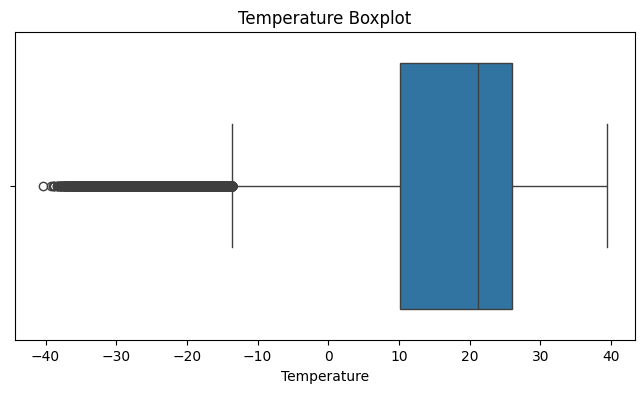

In [37]:
#based on this source: https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/

# Calculate IQR
Q1 = df_imputed['Temperature'].quantile(0.25)
Q3 = df_imputed['Temperature'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calculate outliers
outliers = df_imputed[(df_imputed['Temperature'] < lower_bound) | (df_imputed['Temperature'] > upper_bound)]

# Print the number of outliers and the country and date they correspond to
print(f'Number of outliers detected: {len(outliers)}')
print(outliers[['Country', 'Date', 'Temperature']].head())

# Create a boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='Temperature', data=df_imputed)
plt.title(f'{'Temperature'} Boxplot')
plt.show()


As we can see there are  7794 `Temperature` outliers in the dataset.

From the boxplots we can also see that all the outliers are on the lower end of the `Temperature` range, and there are no postive `Temperature` values that are outliers.

D. Compute summary statistics for `Temperature`, `Monthly_variation`, and `Anomaly` values, including mean, median, standard deviation, and range. 

In [38]:
# Get summary statistics
print(df_imputed.describe())

# Calculate the range (not included in the summary statistics)
print("Temperature range: ", max(df_imputed['Temperature']) - min(df_imputed['Temperature']))
print("Monthly_variation range: ", max(df_imputed['Monthly_variation']) - min(df_imputed['Monthly_variation']))
print("Anomaly range: ", max(df_imputed['Anomaly']) - min(df_imputed['Anomaly']))

         Temperature  Monthly_variation        Anomaly
count  534571.000000      534571.000000  534571.000000
mean       17.264367          -0.084572       0.886305
std        11.137214           1.205020       1.055628
min       -40.349000         -10.566000       0.037000
25%        10.146000          -0.646000       0.300000
50%        21.172000          -0.092000       0.496500
75%        25.958000           0.512000       1.006000
max        39.384000          11.817000      12.203000
Temperature range:  79.733
Monthly_variation range:  22.383000000000003
Anomaly range:  12.165999999999999


`Temperature`:
mean= 17.264367
median= 21.172000
standard deviation= 11.137214 
range= 79.733


`Monthly_variation`:
mean= -0.084572
median= -0.092000
standard deviation= 1.205020 
range= 22.383000000000003


`Anomaly`:
mean= 0.886305
median= 0.496500
standard deviation= 1.055628
range=  12.165999999999999

E. Identify the countries included in the dataset and calculate their average temperature values

In [39]:
# Get all of the country names
df_imputed.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bahrain', 'Baker Island', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bonaire, Saint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burma',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Christmas Island', 'Colombia', 'Comoros', 'Congo',
       'Congo (Democratic Republic of the)', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Denmark (Europe)',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea',

In [40]:
# Calculate average temperature for each country
average_temperatures = df_imputed.groupby('Country')['Temperature'].mean()
print(average_temperatures)


Country
Afghanistan       14.060215
Albania           12.755260
Algeria           23.402849
American Samoa    26.758451
Andorra           11.135316
                    ...    
Virgin Islands    26.444408
Western Sahara    23.858714
Yemen             26.195879
Zambia            21.378978
Zimbabwe          21.187506
Name: Temperature, Length: 233, dtype: float64


233 total countries, their average temperatures and all the names are printed above

F. Determine the overall trend in global temperatures over the years and visualize this trend using a suitable chart

C:\Users\User\AppData\Local\Temp\ipykernel_11080\3786681026.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_imputed['Year'] = pd.to_datetime(df_imputed['Date']).dt.year


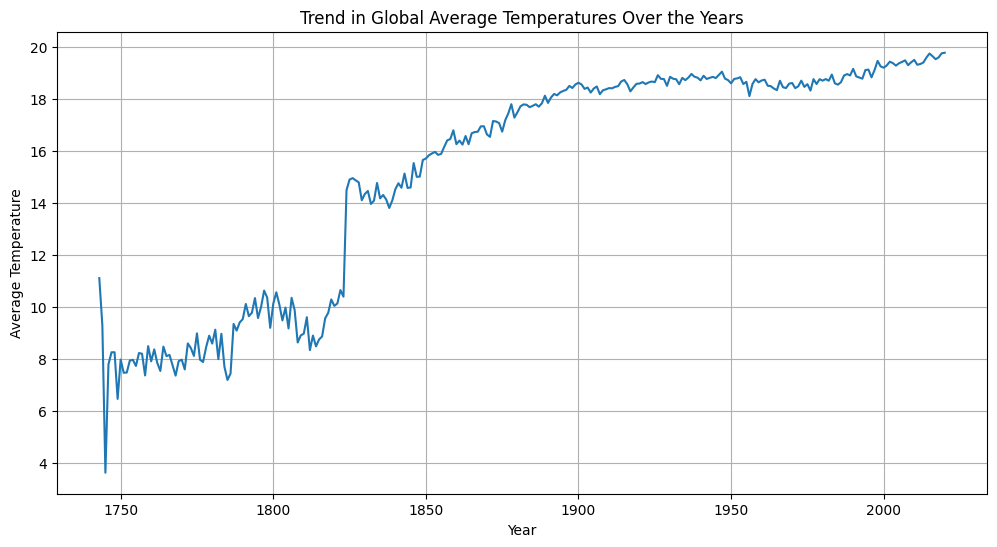

In [41]:
# Get the year from the date
df_imputed['Year'] = pd.to_datetime(df_imputed['Date']).dt.year

# Calculate the average temperature for every year
average_temperatures = df_imputed.groupby('Year')['Temperature'].mean().reset_index()

# Plot the year vs average temperature
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Temperature', data=average_temperatures)
plt.title('Trend in Global Average Temperatures Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.grid(True)
plt.show()


In [42]:
# Drop the year column we just calculated
df_imputed.drop(columns=['Year'], inplace=True)

Global temperature appears to be increasing over time. There is a sharp increase around 1825, and has steadily been increasing since then.

G. Identify the months with the highest and lowest temperatures for each country and find out whether there are noticeable seasonal patterns in the temperature data. 

In [43]:
# Recreate the month column from the Date column
df_imputed['Month'] = pd.to_datetime(df_imputed['Date']).dt.month

# Find min temperature and its corresponding month for each country - group by country and use min on temperature
min_temps = df_imputed.loc[df_imputed.groupby('Country')['Temperature'].idxmin()]
min_temps = min_temps[['Country', 'Month', 'Temperature']]
min_temps.columns = ['Country', 'Min_Temperature_Month', 'Min_Temperature']

# Find max temperature and its corresponding month for each country - group by country and use max on temperature
max_temps = df_imputed.loc[df_imputed.groupby('Country')['Temperature'].idxmax()]
max_temps = max_temps[['Country', 'Month', 'Temperature']]
max_temps.columns = ['Country', 'Max_Temperature_Month', 'Max_Temperature']

# Save results as a datadrame and print them
temp_extremes = pd.merge(min_temps, max_temps, on='Country')
print(temp_extremes)


C:\Users\User\AppData\Local\Temp\ipykernel_11080\570292238.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_imputed['Month'] = pd.to_datetime(df_imputed['Date']).dt.month


            Country  Min_Temperature_Month  Min_Temperature  \
0       Afghanistan                      1           -4.588   
1           Albania                      1           -2.421   
2           Algeria                      1            9.807   
3    American Samoa                      7           24.988   
4           Andorra                      1           -1.082   
..              ...                    ...              ...   
228  Virgin Islands                      2           23.094   
229  Western Sahara                      1           14.167   
230           Yemen                     12           18.684   
231          Zambia                      7           15.343   
232        Zimbabwe                      7           13.890   

     Max_Temperature_Month  Max_Temperature  
0                        7           28.867  
1                        7           26.041  
2                        7           36.157  
3                        2           29.122  
4            

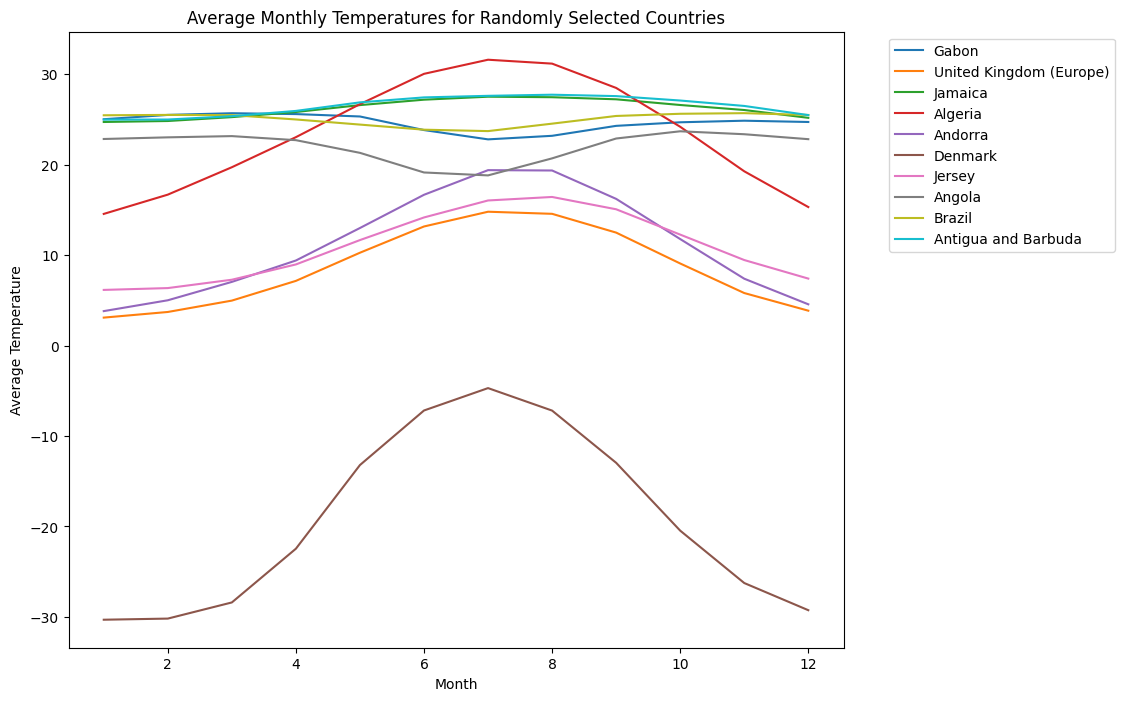

In [44]:
# Randomly select countries to plot 
selected_countries = random.sample(list(df_imputed['Country'].unique()), 10)

# Select the randomly selected countries
selected_data = df_imputed[df_imputed['Country'].isin(selected_countries)]

# Calculate average temperature for each month for each country
monthly_avg_temps = selected_data.groupby(['Country', 'Month'])['Temperature'].mean().reset_index()


plt.figure(figsize=(10, 8))

# Plot average temperature per month for each country
for country in selected_countries:
    country_data = monthly_avg_temps[monthly_avg_temps['Country'] == country]
    sns.lineplot(x='Month', y='Temperature', data=country_data, label=country)

plt.title('Average Monthly Temperatures for Randomly Selected Countries')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


There appears to be a seasonality pattern. For most countries the temperature is at its lowest at the beginning and end of the year, and is at its highest around month 7-8. For some countries they have a consistent temperature throughout the year. Lastly, for the remaining countries they have an inverse pattern where the highest temperatures are at the beginning and end of the year, and lowest temperatures are around month 7. 
The above plot will randomly select 10 countries to show, so I can plot it multiple times to see if these observations remain consistent as the countries shown change.

h. Explore the variation in temperature anomalies on a monthly basis and identify any months with consistently high or low anomalies across the years.

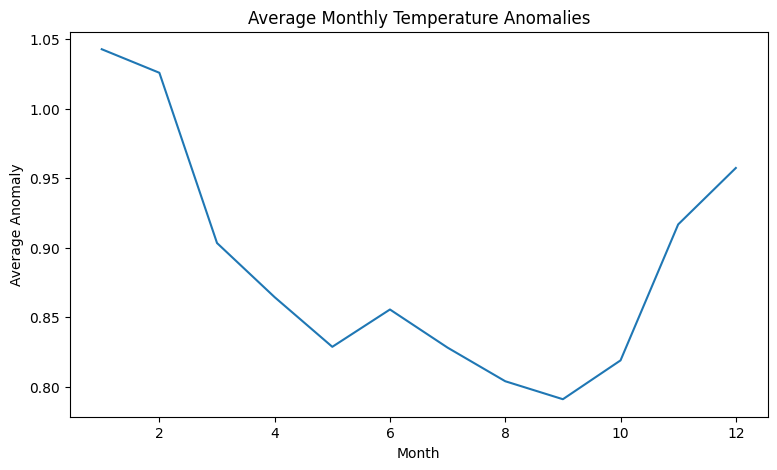

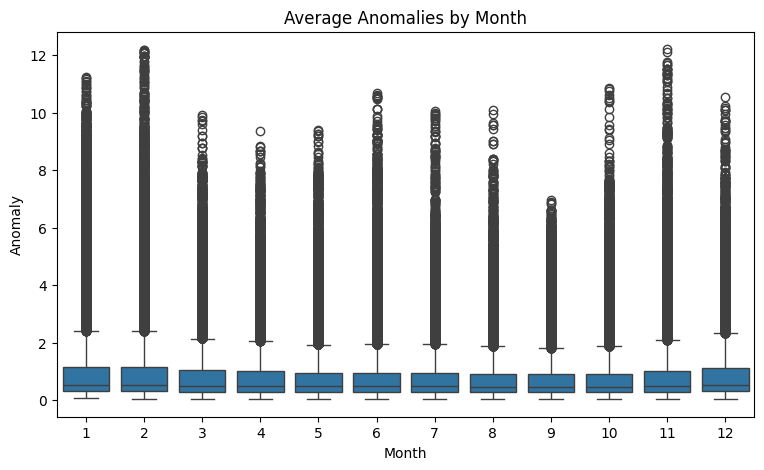

In [45]:

# Calculate the mean and standard deviation for anomalies -group by month
monthly_anomalies = df_imputed.groupby('Month')['Anomaly'].agg(['mean', 'std']).reset_index()

# Plot mean anomaly per month
plt.figure(figsize=(9, 5))
sns.lineplot(x='Month', y='mean', data=monthly_anomalies)
plt.title('Average Monthly Temperature Anomalies')
plt.xlabel('Month')
plt.ylabel('Average Anomaly')
plt.show()

# Boxplot to show variation
plt.figure(figsize=(9, 5))
sns.boxplot(x='Month', y='Anomaly', data=df_imputed)
plt.title('Average Anomalies by Month')
plt.xlabel('Month')
plt.ylabel('Anomaly')
plt.show()


Month 9 consistently has the lowest average temperature anomalies. Months 1 and 2 consistently have the highest average temperature anomalies. In general, the months at the beginning and end of the year have the highest anomalies, and the months in the middle of the year have the lowest anomalies.
The boxplot shows us the variation in anomalies. Although the average anomaly is fairly small range for all the months (0.8 - 1.05), the boxplots show us the range of outliers. We can see that beginning and end months appear to have more outliers than middle of the year months, especialy month 9.

In [46]:
# Drop the month column
df_imputed.drop(columns=['Month'], inplace=True)
df_imputed.head()

,Country,Temperature,Monthly_variation,Anomaly,Date
0,Afghanistan,19.573,-0.297,2.037,05-1848
1,Afghanistan,23.894,-0.796,2.136,06-1848
2,Afghanistan,26.507,-0.113,1.937,07-1848
3,Afghanistan,24.498,-0.462,1.937,08-1848
4,Afghanistan,19.068,-1.272,1.865,09-1848


i. Choose five countries and compare the trends in their temperatures over the years, seeking any similar temperature patterns. 

C:\Users\User\AppData\Local\Temp\ipykernel_11080\3323339702.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_imputed['Year'] = pd.to_datetime(df_imputed['Date']).dt.year


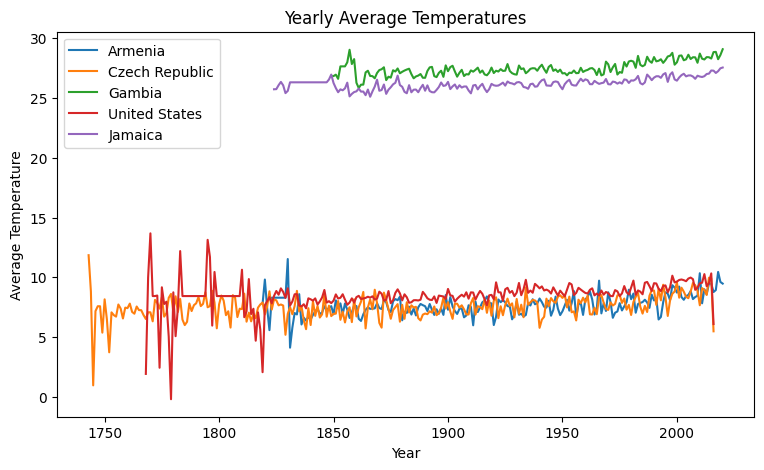

In [47]:
# Get the year from the date
df_imputed['Year'] = pd.to_datetime(df_imputed['Date']).dt.year

# Calculate the average temperature for each year for each country
yearly_avg_temps = df_imputed.groupby(['Country', 'Year'])['Temperature'].mean().reset_index()

# Select countries
countries_to_plot = ['Armenia', 'Czech Republic', 'Gambia', 'United States', 'Jamaica'] 

plt.figure(figsize=(9, 5))

# Loop through countries and plot the yearly avg temp
for country in countries_to_plot:
    country_data = yearly_avg_temps[yearly_avg_temps['Country'] == country]
    sns.lineplot(x='Year', y='Temperature', data=country_data, label=country)

plt.title('Yearly Average Temperatures')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.show()


I selected to Armenia, Czech Republic, Gambia, United States, and Jamaica as my 5 countries to investigate. I selected these countries because they are in geographically different regions and I wanted to see if that would affect the trends I saw. Overall the average temperatures for each country appears to be increasing over time. Armenia, Czech Republic, and United States all have similiar average temperatures. Gambia and Jamaica have similar average temperatures to each other, and the 2 have higher average temperatures than the other 3 countries. Despite these temperature differences all 5 countries appear to be increasing in yearly average temperature.
However, at the end of the dataset Czech Republic and the United States appear to have a decrease in yearly temperature, but had been increasing up until the point.

j. Explore the potential correlation between temperature and monthly variation or anomaly values. Calculate correlation coefficients and create scatterplots to investigate this relationship.

In [48]:
correlation_temp_monthly_variation = df_imputed[['Temperature', 'Monthly_variation']].corr()
correlation_temp_anomaly = df_imputed[['Temperature', 'Anomaly']].corr()

print(correlation_temp_monthly_variation)
print(correlation_temp_anomaly)

                   Temperature  Monthly_variation
Temperature           1.000000           0.159717
Monthly_variation     0.159717           1.000000
             Temperature   Anomaly
Temperature     1.000000 -0.318608
Anomaly        -0.318608  1.000000


The correlation coefficient for `Temperature` and `Monthly_variation` is 0.159717 

The correlation coefficient for `Temperature` and `Anomaly` is -0.318608  

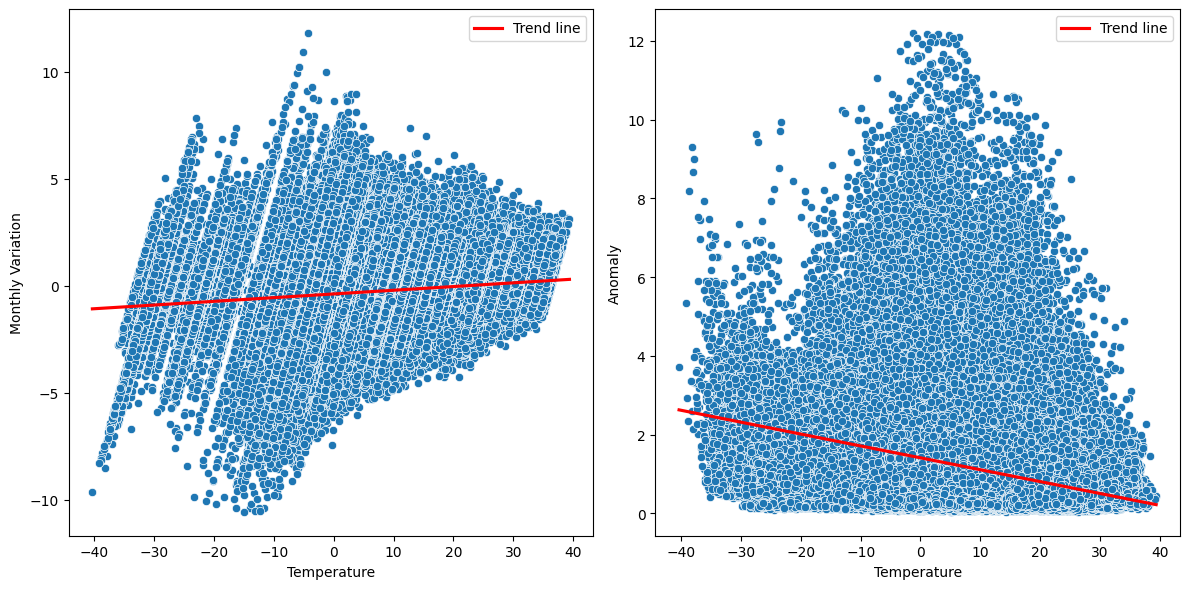

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Temperature', y='Monthly_variation', data=df_imputed)
sns.regplot(x='Temperature', y='Monthly_variation', data=df_imputed, scatter=False, color='red', label='Trend line')
plt.xlabel('Temperature')
plt.ylabel('Monthly Variation')
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x='Temperature', y='Anomaly', data=df_imputed)
sns.regplot(x='Temperature', y='Anomaly', data=df_imputed, scatter=False, color='red', label='Trend line')
plt.xlabel('Temperature')
plt.ylabel('Anomaly')
plt.legend()

plt.tight_layout()
plt.show()

There is a slight positive relationship between `Temperature` and `Monthly_variation` and a negative relationship between  `Temperature` and `Anomaly` as shown in the trendlines and correlation coefficients

k. Provide an intriguing insight from the dataset by utilizing data visualization techniques such as histograms, box plots, or heatmaps to represent the data's distribution, trends, and relationships. 

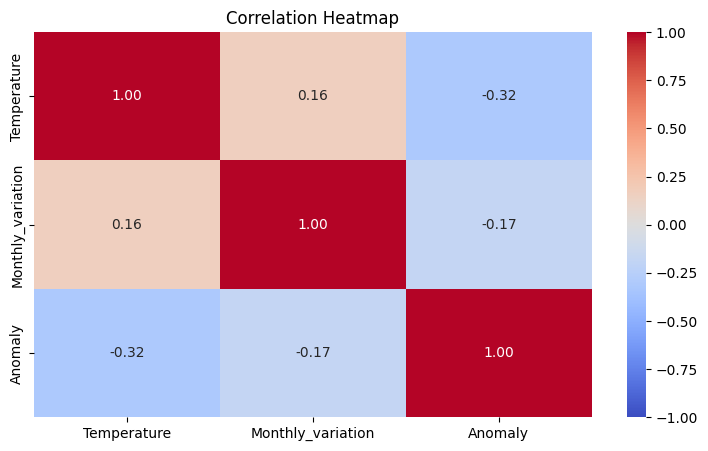

In [50]:
correlation = df_imputed[['Temperature', 'Monthly_variation', 'Anomaly']].corr()
plt.figure(figsize=(9, 5))  

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, xticklabels=correlation.columns, yticklabels=correlation.columns)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows the correlation between `Temperature`, `Monthly_variation`, and `Anomaly`

`Temperature` and `Anomaly` have the strongest correlation of -0.32. `Monthly_variation` and `Anomaly` also have a negative correlation of -0.17. And `Temperature` and `Monthly_variation` have a positive correlation of 0.16.
A positive correlation means that as one feature increase, the other will also increase (ie as `Temperature` increases so does the number of `Monthly_variation`). A negative correlation means that as one feature increases the other decreases (ie as `Temperature` or `Monthly_variation` increases the number of `Anomaly` decreases).

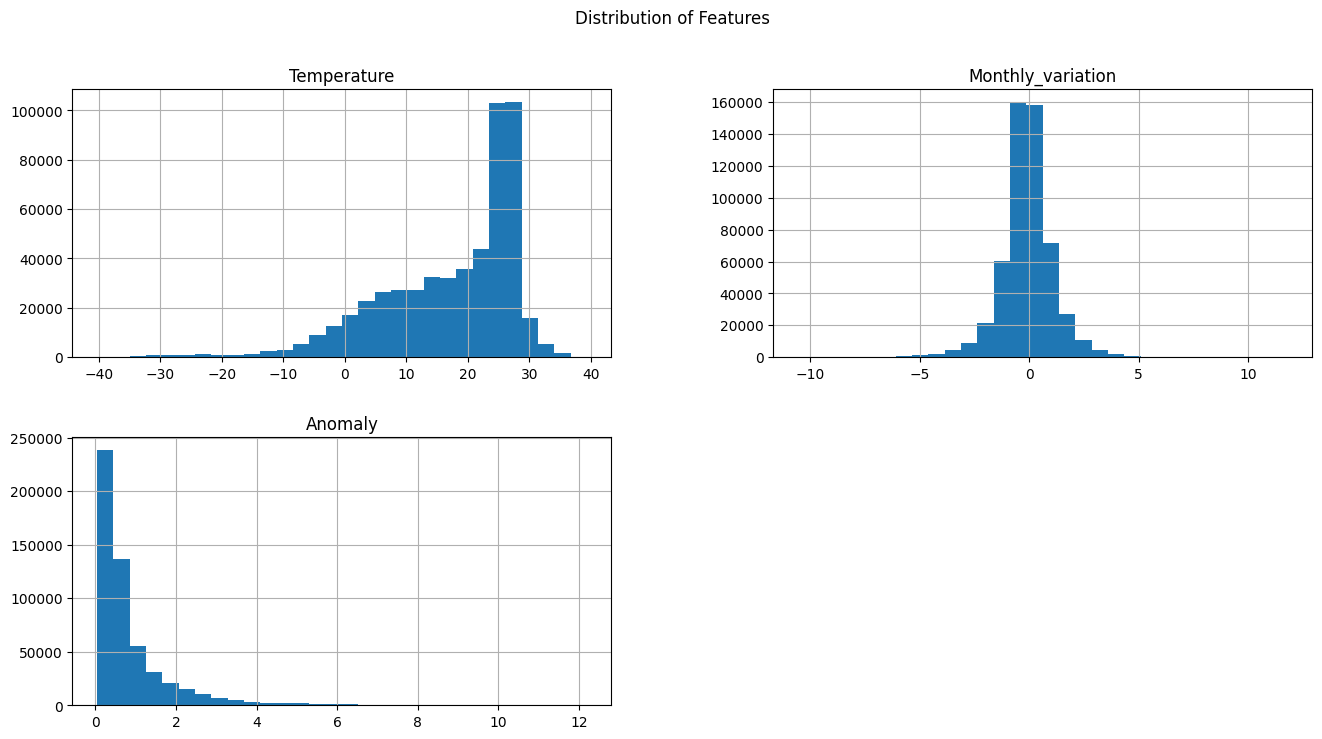

In [51]:
df_imputed[['Temperature', 'Monthly_variation', 'Anomaly']].hist(bins=30, figsize=(16, 8))
plt.suptitle('Distribution of Features')
plt.show()

`Monthly_variation` appears to follow a roughly normal distribution, but `Temperature` and `Anomaly` have skewed distributions. `Temperature` has a left skew, with more of the values being aorund 20-30 degrees, whereas `Anomaly` has a right skew with more of the values being around 0-1.